In [16]:
import pandas as pd
import numpy as np
import string
from bs4 import BeautifulSoup
import unidecode
from word2number import w2n
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn import metrics
from numpy import mean
from numpy import std


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
from sklearn.feature_selection import VarianceThreshold

In [17]:
train_data = pd.read_csv("Train.csv", sep=',')
train_data.drop(train_data.filter(regex="Unnamed"), axis =1, inplace= True)
train_data.drop(train_data.filter(regex="id"), axis =1, inplace= True)
test_data = pd.read_csv("Test.csv", sep=',')
test_data.drop(train_data.filter(regex="Unnamed"), axis =1, inplace= True)
test_data.drop(train_data.filter(regex="id"), axis =1, inplace= True)

In [18]:
#remove URL and @xxx from text
def to_lower(text):
    text = text.lower()
    return text
def remove_url_and_at(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    return text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#remove extra whitespaces from text
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#remove html tags from text
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#remove accented characters from text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#expand contractions in text
def expand_contractions(text):
    #expand shortened words
    text = contractions.fix(text)
    return text

# standardize emoji
def emotion(text):
    text = re.sub(r':\)|:D|: \)|=\)|:-\)', " :) ", text)
    text = re.sub(r':\(|: \(|:-\(', " :(  ", text)                      
    return text

#remove punctuation beside !&?
def remove_punc_and_number(text):
    punctuation = list(string.punctuation)
    punctuation.remove('?')
    punctuation.remove('!')
    for i in range(len(text)):
        if text[i] in punctuation:
            if i+1 <= len(text)-1:
                if (text[i] == ":") and (text[i+1] == "(" or text[i+1] == ")"):
                    continue
            if i >= 1:
                if (text[i] == ")" or text[i] == "(") and (text[i-1] == ':'):
                    continue
            text = text.replace(text[i], ' ')
    text = re.sub(r'[0-9]+', '', text)
    return text


#extract !&?
def create_whitespace(text):
    text = re.sub(r'\?+', ' ? ', text)
    text = re.sub(r'!+', ' ! ', text)              
    return text

#remove words have <=2 length
def remove_shortwords(filtered_sentence):
    return_list=[]
    for word in filtered_sentence:
        if len(word) > 2:
            return_list.append(word)
    return  return_list

#lemitization
def lemmetize_print(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

# remove stop words from text
# exclude words "no","not",from stopwords list
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')

def remove_stopwords(text):
    text_lst = text.split(" ")
    for word in text_lst:
        if word in stop_words:
            text_lst.remove(word)
    return text_lst

def remove_deplicated_charac(text):
    text = re.sub("(.)\\1{2,}", "\\1", text)
    return text

def remove_deplicated_charac2(text):
    text_lst = text.split(" ")
    for i in range(len(text_lst)):
        text_lst[i] = re.sub("^(.)\\1{1,}","\\1" ,text_lst[i])
    return " ".join(text_lst)

In [19]:
#preprocessing text
from collections import Counter
import pycountry


frequency = Counter()
month = ["january", "february", "march", "april", "june", "july", "august", "september", "october", "november","december"]
number =["one","two","three","four","five","six","seven","eight","nine","ten"]
countries= []
for p in pycountry.countries:
    p = p.name.lower()
    countries.append(p)
    
    
def clean_text_instance(df):
    for i in range(len(df["text"])):
        text = df["text"][i]
        text = to_lower(text)
        text = df["text"][i]
        text = contractions.fix(text) 
        text = remove_deplicated_charac(text)
        text = remove_deplicated_charac2(text)
        text = remove_accented_chars(text)
        text = remove_url_and_at(text)
        text = strip_html_tags(text)
        text = emotion(text)
        text = remove_punc_and_number(text)
        text = create_whitespace(text)
        text = remove_whitespace(text)
        text = lemmetize_print(text)

        #word_tokens = word_tokenize(text)
        stop_word_removed_list = remove_stopwords(text) 
        new_filtered_sentence = remove_shortwords(stop_word_removed_list)
        #record number of occurance for unique words
        frequency.update(new_filtered_sentence)
        new_sentence = " ".join(new_filtered_sentence)
        df.iloc[i,df.columns.get_loc('text')] = new_sentence
    #keep only words with more than 2 occurace
    for i in range(len(df["text"])):
        word_list = df["text"][i].split()
        new_word_list = [word for word in word_list if frequency[word] >3]
        new_word_list = [word for word in word_list if frequency[word] <7000]
        new_word_list = [word for word in word_list if word not in month]
        new_word_list = [word for word in word_list if word not in number]
        new_word_list = [word for word in word_list if word not in countries]
        new_sentence = " ".join(new_word_list)
        df.iloc[i,df.columns.get_loc('text')]= new_sentence 

In [20]:
clean_text_instance(test_data)
clean_text_instance(train_data)

In [21]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
y_train_ori = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [22]:
# vetorisation using BoW
from sklearn.feature_extraction.text import CountVectorizer
BoW_vectorizer = CountVectorizer(analyzer ='word', ngram_range =(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)
#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
#X_val_BoW = BoW_vectorizer.transform(X_val)
print("Train feature space size a(using BoW):",X_train_BoW.shape)
#print("Test feature space size (using BoW):",X_val_BoW.shape)
#print(len(y_train))

Train feature space size a(using BoW): (21802, 174049)


In [23]:
#remove feature with low variance
threshold = 0.0001
selector = VarianceThreshold(threshold  = threshold)
X_train_BoW_var = selector.fit_transform(X_train_BoW,y_train_ori)
#X_val_BoW_var = selector.transform(X_val_BoW)
print("Train feature space size (using BoW):",X_train_BoW_var.shape)
#print("Test feature space size (using BoW):",X_val_BoW_var.shape)
#print("Dimension of y_train:",len(y_train))

Train feature space size (using BoW): (21802, 15683)


In [24]:
#feature selection select K best feature using BoW
k_best1 = 3000
select_k_best = SelectKBest(f_classif, k = k_best1)
X_train_BoW_var_selectk = select_k_best.fit_transform(X_train_BoW_var, y_train_ori)
#X_val_BoW_var_selectk = select_k_best.transform(X_val_BoW_var)
print("Train feature space size (using BoW):",X_train_BoW_var_selectk.shape)
#print("Test feature space size (using BoW):",X_val_BoW_var_selectk.shape)

Train feature space size (using BoW): (21802, 3000)


In [25]:
#oversampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_BoW_var_selectk_over, y_train_over = oversample.fit_resample(X_train_BoW_var_selectk, y_train_ori)


In [26]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

SVMclf = SVC(kernel = 'linear',
                 C = 2,
                 decision_function_shape = 'ovo',
                 class_weight = 'balanced')
LRclf = LogisticRegression(random_state = 42,
                               solver = 'saga', 
                               multi_class = 'multinomial',
                               C = 1.5,
                               max_iter = 500,
                               class_weight = 'balanced')
MNBclf= MultinomialNB(alpha =1,
                         fit_prior = False)

estimators =[("svm",SVMclf),("mnb", MNBclf)]
Stackingclf = StackingClassifier(estimators =estimators, final_estimator = LRclf)

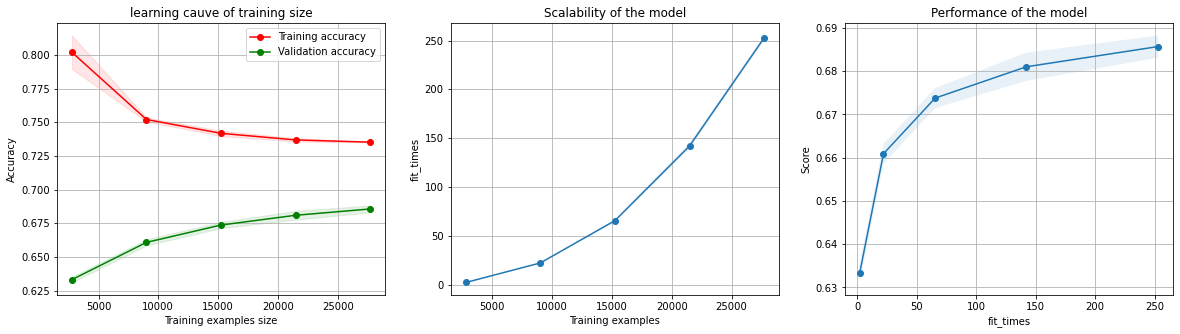

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples size")
    axes[0].set_ylabel("Accuracy")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training accuracy"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Validation accuracy"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

from sklearn.model_selection import train_test_split
cv = ShuffleSplit(n_splits=4, test_size=0.27, random_state=0)

plot_learning_curve(Stackingclf, "learning cauve of training size", X_train_BoW_var_selectk_over, y_train_over, cv = cv)
plt.show()